<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments/blob/main/Models2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PROVA MODELLI CENTRALIZZATI PREDIZIONE INVOCATIONS' RATE**



#### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

from datasets import load_dataset

# Data

In [ ]:
dataset_60 = load_dataset("anastasiafrosted/globus_60", download_mode="force_redownload")
dataset_300 = load_dataset("anastasiafrosted/globus_300", download_mode="force_redownload")
dataset_3600 = load_dataset("anastasiafrosted/globus_3600", download_mode="force_redownload")
dataset_86400 = load_dataset("anastasiafrosted/globus_86400", download_mode="force_redownload")

df_60 = pd.DataFrame(dataset_60['train'])
df_300 = pd.DataFrame(dataset_300['train'])
df_3600 = pd.DataFrame(dataset_3600['train'])
df_86400 = pd.DataFrame(dataset_86400['train'])

# Ensure the `timestamp` column is in datetime format
df_60['timestamp'] = pd.to_datetime(df_60['timestamp'])
df_300['timestamp'] = pd.to_datetime(df_300['timestamp'])
df_3600['timestamp'] = pd.to_datetime(df_3600['timestamp'])
df_86400['timestamp'] = pd.to_datetime(df_86400['timestamp'])

In [189]:
data = df_86400
data = data.set_index("timestamp")
#data.head()

In [196]:
train_data = data["2022-12-20":"2023-06-14"]
valid_data = data["2023-06-15":"2023-07-01"]
test_data = data["2023-07-01":]

#### Scaling

In [197]:
from sklearn.preprocessing import StandardScaler

# Crea un'istanza dello scaler
scaler = StandardScaler()

# Per il dataset di training
scaled_train = train_data.copy()
scaled_train[scaled_train.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    train_data[train_data.columns.drop('avg_invocations_rate')]
)
train = scaled_train

# Per il dataset di validazione
scaled_valid = valid_data.copy()
scaled_valid[scaled_valid.columns.drop('avg_invocations_rate')] = scaler.transform(
    valid_data[valid_data.columns.drop('avg_invocations_rate')]
)
valid = scaled_valid

# Per il dataset di test
scaled_test = test_data.copy()
scaled_test[scaled_test.columns.drop('avg_invocations_rate')] = scaler.transform(
    test_data[test_data.columns.drop('avg_invocations_rate')]
)
test = scaled_test

#### Config (Parameters)

In [198]:
batch_size = 32
num_features = 12
sequence_lenght = 7
prediction_lenght = 7
seed = 42

# Models

## Forecasting one-step-ahead

In [199]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=5):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

### Univariate series

In [200]:
tr = train['avg_invocations_rate']
vl = valid['avg_invocations_rate']

In [201]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    tr.to_numpy(),
    targets=tr[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    vl.to_numpy(),
    targets=vl[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Linear Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_lenght])
])

In [203]:
fit_and_evaluate(model, train_ds, valid_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0031 - mae: 0.0615 - val_loss: 0.0023 - val_mae: 0.0550
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0021 - mae: 0.0505 - val_loss: 0.0016 - val_mae: 0.0467
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0017 - mae: 0.0439 - val_loss: 0.0011 - val_mae: 0.0377
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017 - mae: 0.0440 - val_loss: 8.7370e-04 - val_mae: 0.0318
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0013 - mae: 0.0400 - val_loss: 7.9554e-04 - val_mae: 0.0316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 7.9554e-04 - mae: 0.0316


31557.120382785797

#### Simple RNN

Recall that the input_shape argument ignores
the first dimension (i.e., the batch size), and since recurrent layers can accept
input sequences of any length, we can set the second dimension to None, which
means “any size”. Lastly, since we’re dealing with a univariate time series, we
need the last dimension’s size to be 1. This is why we specified the input shape
* [None, 1] : it means “univariate sequences of any length”.


In [ ]:
univar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(batch_size, input_shape=[None, 1]),
  tf.keras.layers.Dense(1) # no activation function by default
])

In [205]:
fit_and_evaluate(univar_model, train_ds, valid_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0016 - mae: 0.0418 - val_loss: 9.5208e-04 - val_mae: 0.0293
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - mae: 0.0436 - val_loss: 0.0010 - val_mae: 0.0302
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - mae: 0.0417 - val_loss: 8.3098e-04 - val_mae: 0.0307
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - mae: 0.0404 - val_loss: 8.5524e-04 - val_mae: 0.0292
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012 - mae: 0.0364 - val_loss: 9.4317e-04 - val_mae: 0.0294
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 8.5524e-04 - mae: 0.0292


29226.571321487427

#### Deep RNN

In [206]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [209]:
fit_and_evaluate(deep_model, train_ds, valid_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0019 - mae: 0.0484 - val_loss: 0.0018 - val_mae: 0.0426
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019 - mae: 0.0446 - val_loss: 0.0011 - val_mae: 0.0369
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0015 - mae: 0.0444 - val_loss: 0.0014 - val_mae: 0.0380
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0015 - mae: 0.0421 - val_loss: 0.0011 - val_mae: 0.0364
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0015 - mae: 0.0411 - val_loss: 0.0016 - val_mae: 0.0395
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0011 - mae: 0.0364


36440.592259168625

### Multivariate Series

In [210]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=train['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=valid['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Simple RNN

Notice that the only difference from the univar_model RNN we built earlier
is the input shape: at each time step, the model now receives num_features inputs instead of one.

In [ ]:
mulvar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(batch_size, input_shape=[None, num_features]),
  tf.keras.layers.Dense(1)
])

In [212]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.1669 - mae: 0.4695 - val_loss: 0.1049 - val_mae: 0.2892
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0830 - mae: 0.3184 - val_loss: 0.0537 - val_mae: 0.2186
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0494 - mae: 0.2369 - val_loss: 0.0250 - val_mae: 0.1519
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0312 - mae: 0.1838 - val_loss: 0.0131 - val_mae: 0.1228
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0227 - mae: 0.1576 - val_loss: 0.0072 - val_mae: 0.0935
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0072 - mae: 0.0935


93548.11906814575

## Forecasting Several Time Steps Ahead

### Univariate Series

Consideriamo sempre:
* tr = train['avg_invocations_rate']
* vl = valid['avg_invocations_rate']

#### Simple RNN

The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the inputs,
acting as if the predicted value had actually occurred; we would then use the
model again to predict the following value, and so on.

---
If the model makes an error at one time step, then the forecasts for the
following time steps are impacted as well: the errors tend to accumulate.
So, it’s preferable to use this technique only for a small number of steps.

In [224]:
X = vl.to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


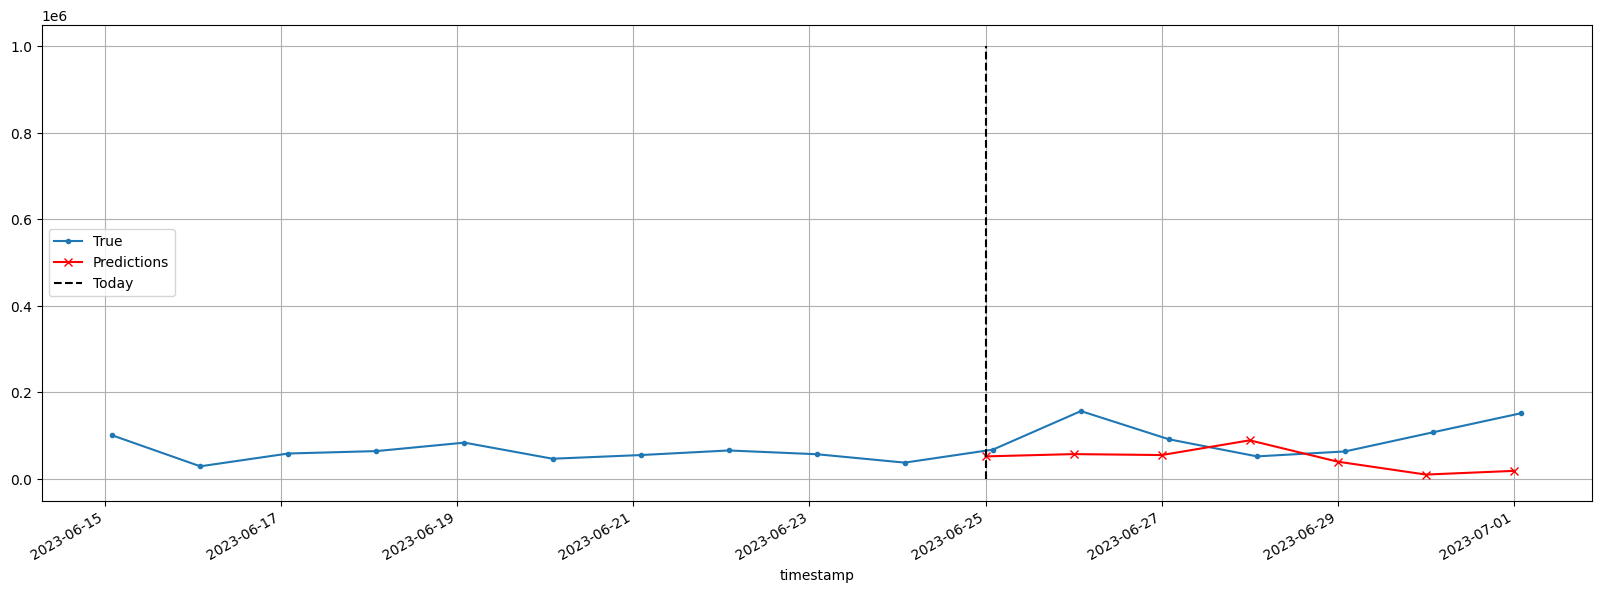

In [225]:
# The forecasts start on 2023-06-01, and they end
# on 2019-06-14. That's 14 days in total.
origin = "2023-06-15"
start = "2023-06-25"
end = "2023-07-01"

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, 0, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

### Multivariate Series

In [218]:
def split_inputs_and_targets(mulvar_series, ahead=prediction_lenght, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

In [217]:
print(len(ahead_train_ds))  # Check the size of your training dataset
print(len(ahead_valid_ds))  # Check the size of your validation dataset

5
1


#### Sequence-to-Vector RNN

Train an RNN to predict the next 14 values in one shot.

In [219]:
ahead_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(batch_size, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [220]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.5009 - mae: 0.8787 - val_loss: 0.2512 - val_mae: 0.6422
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4648 - mae: 0.8317 - val_loss: 0.1765 - val_mae: 0.5355
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4415 - mae: 0.8006 - val_loss: 0.1383 - val_mae: 0.4632
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4145 - mae: 0.7634 - val_loss: 0.1251 - val_mae: 0.4408
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3997 - mae: 0.7399 - val_loss: 0.1230 - val_mae: 0.4458
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1251 - mae: 0.4408


440836.5488052368

In [227]:
X = valid.to_numpy()[np.newaxis, :sequence_lenght]

Y_pred = ahead_model.predict(X) # shape [1, 14]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


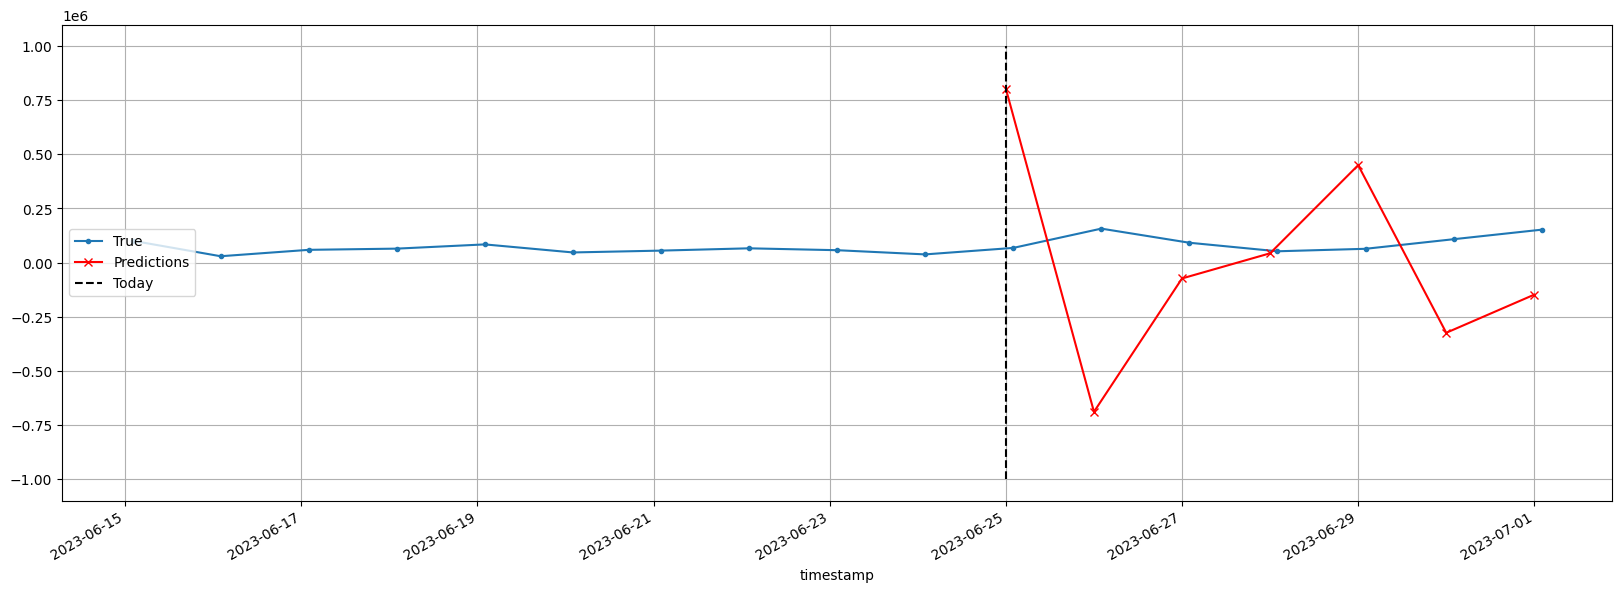

In [229]:
# The forecasts start on 2023-06-01, and they end
# on 2019-06-14. That's 14 days in total.
origin = "2023-06-15"
start = "2023-06-25"
end = "2023-07-01"

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start, end))

fig, ax = plt.subplots(figsize=(20, 7))
(vl * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### Sequence-to-Sequence RNN

In [234]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(8 * batch_size, seed=seed)
  return ds.batch(batch_size)

In [235]:
seq2seq_train = to_seq2seq_dataset(train, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid = to_seq2seq_dataset(valid, seq_length=sequence_lenght, ahead=prediction_lenght)

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step.
In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.

* The targets are sequences of consecutive windows, shifted by one time step at each time step;
* The target is not a vector anymore, but a sequence of the same length as the inputs, containing a (prediction_lenght)-dimensional vector at each step.

In [236]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(batch_size, return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [237]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid)

Epoch 1/5
      1/Unknown 1s 1s/step - loss: 0.5281 - mae: 0.9205

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.4940 - mae: 0.8747 - val_loss: 0.3013 - val_mae: 0.6853
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4656 - mae: 0.8399 - val_loss: 0.2674 - val_mae: 0.6455
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4516 - mae: 0.8191 - val_loss: 0.2336 - val_mae: 0.6006
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4249 - mae: 0.7857 - val_loss: 0.2075 - val_mae: 0.5617
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4228 - mae: 0.7807 - val_loss: 0.1865 - val_mae: 0.5288
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1865 - mae: 0.5288


528830.9454917908